
# Lung Cancer Dataset Analysis

This notebook provides a comprehensive analysis of the lung cancer dataset, focusing on data cleaning, exploratory data analysis (EDA), feature engineering, and predictive modeling. It aims to derive insights and predict outcomes related to lung cancer using advanced techniques.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lifelines import KaplanMeierFitter

file_path = './data/lung_cancer_data.csv'
data = pd.read_csv(file_path)

print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Patient_ID                 300000 non-null  int64  
 1   Age                        300000 non-null  int64  
 2   Gender                     300000 non-null  object 
 3   Smoking_History            300000 non-null  object 
 4   Years_Smoked               300000 non-null  int64  
 5   Pack_Years                 300000 non-null  int64  
 6   Family_History_Cancer      300000 non-null  bool   
 7   Occupation                 300000 non-null  object 
 8   Exposure_to_Toxins         300000 non-null  bool   
 9   Residential_Area           300000 non-null  object 
 10  BMI                        300000 non-null  float64
 11  Lung_Function_Test_Result  300000 non-null  float64
 12  Chest_Pain_Symptoms        300000 non-null  bool   
 13  Shortness_of_Breath        30

## Data Cleaning and Preparation

Missing values per column:
 Patient_ID                       0
Age                              0
Gender                           0
Smoking_History                  0
Years_Smoked                     0
Pack_Years                       0
Family_History_Cancer            0
Occupation                       0
Exposure_to_Toxins               0
Residential_Area                 0
BMI                              0
Lung_Function_Test_Result        0
Chest_Pain_Symptoms              0
Shortness_of_Breath              0
Chronic_Cough                    0
Weight_Loss                      0
Physical_Activity_Level          0
Dietary_Habits                   0
Air_Quality_Index                0
Comorbidities                90376
Previous_Cancer_Diagnosis        0
Tumor_Size_cm                    0
Metastasis_Status                0
Stage_of_Cancer                  0
Treatment_Type                   0
Survival_Years                   0
Follow_Up_Visits                 0
Medication_Response        

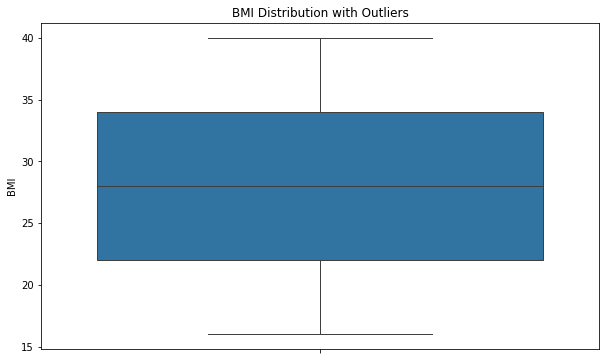

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Patient_ID                 300000 non-null  int64  
 1   Age                        300000 non-null  int64  
 2   Gender                     300000 non-null  object 
 3   Smoking_History            300000 non-null  object 
 4   Years_Smoked               300000 non-null  int64  
 5   Pack_Years                 300000 non-null  int64  
 6   Family_History_Cancer      300000 non-null  bool   
 7   Occupation                 300000 non-null  object 
 8   Exposure_to_Toxins         300000 non-null  bool   
 9   Residential_Area           300000 non-null  object 
 10  BMI                        300000 non-null  float64
 11  Lung_Function_Test_Result  300000 non-null  float64
 12  Chest_Pain_Symptoms        300000 non-null  bool   
 13  Shortness_of_Breath        30

In [2]:

missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

plt.figure(figsize=(10, 6))
sns.boxplot(data['BMI'])
plt.title("BMI Distribution with Outliers")
plt.show()

data = data[(data['BMI'] > 10) & (data['BMI'] < 50)]
print("Cleaned Data Info:\n", data.info())


## Exploratory Data Analysis (EDA)


### Age Distribution


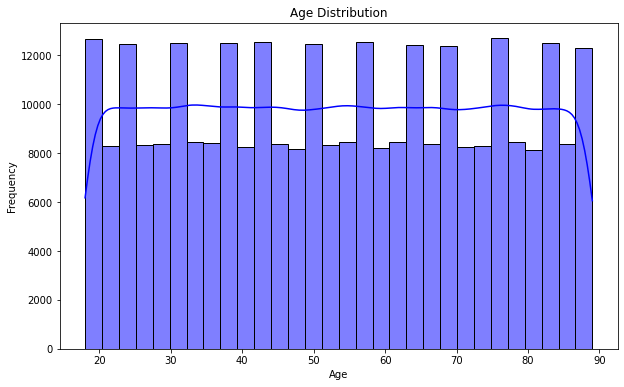

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], kde=True, bins=30, color='blue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


### Smoking History Distribution


/tmp/ipykernel_280748/2597889050.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['Smoking_History'], palette='Set2')


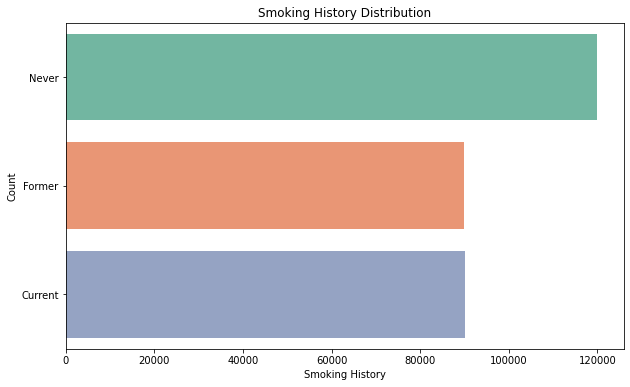

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(data['Smoking_History'], palette='Set2')
plt.title("Smoking History Distribution")
plt.xlabel("Smoking History")
plt.ylabel("Count")
plt.show()


### Correlation Matrix


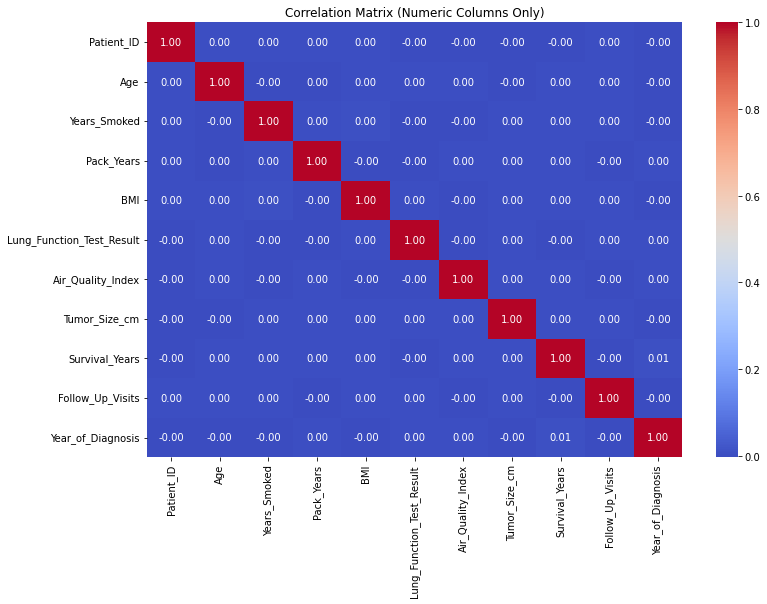

In [5]:

numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()

###  Pairplot for key numeric features

<Figure size 864x720 with 0 Axes>

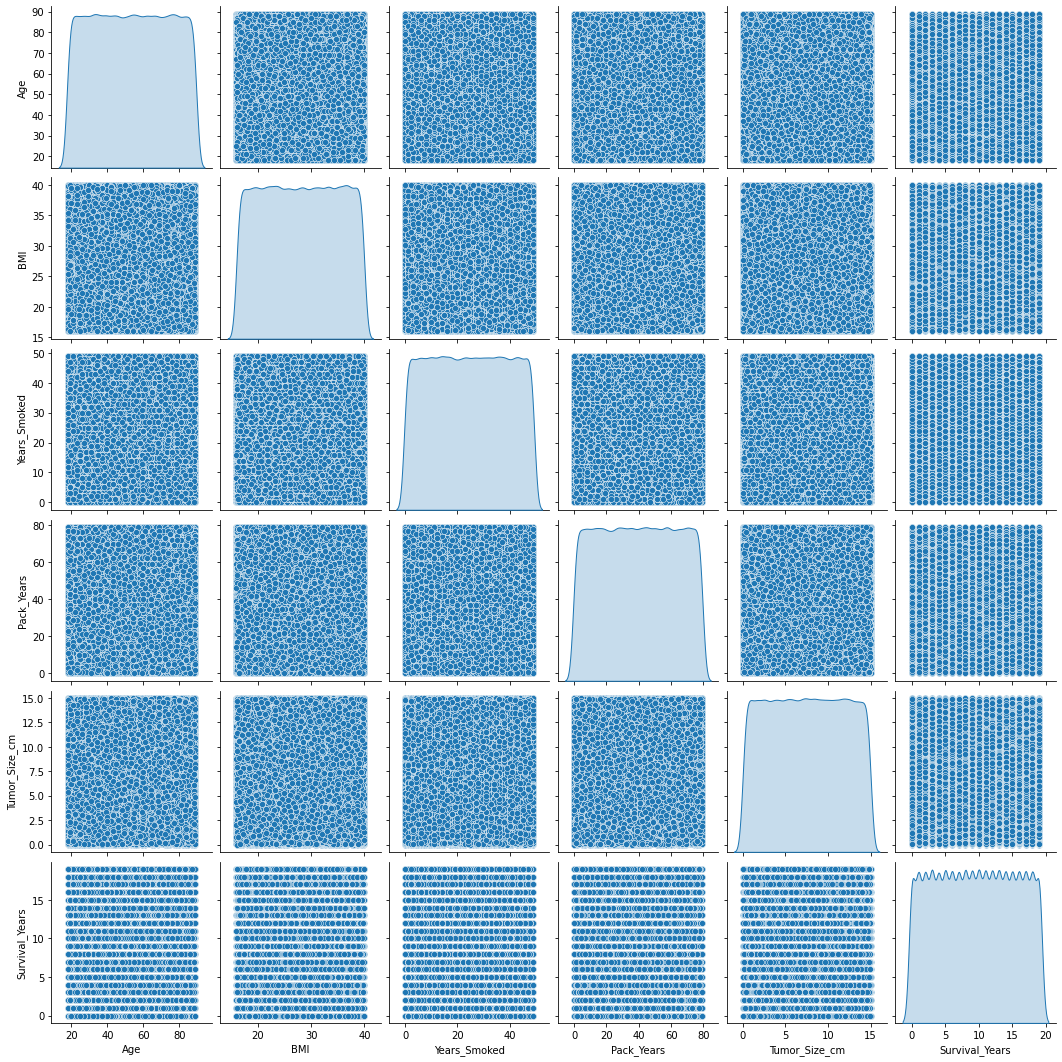

In [6]:

import seaborn as sns
plt.figure(figsize=(12, 10))
sns.pairplot(data[['Age', 'BMI', 'Years_Smoked', 'Pack_Years', 'Tumor_Size_cm', 'Survival_Years']], diag_kind='kde')
plt.show()


### Boxplot for treatment type vs survival year

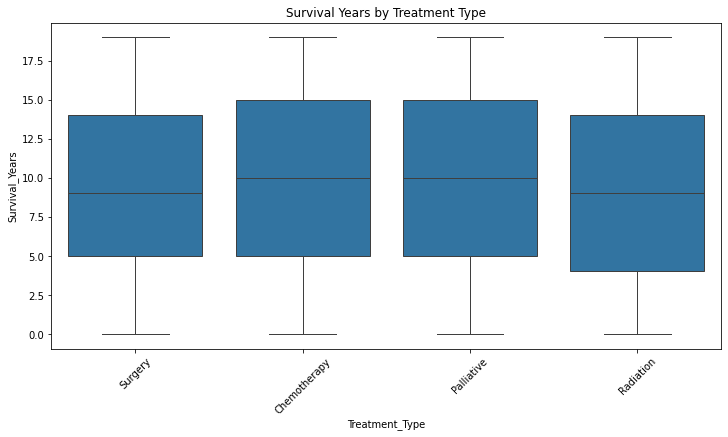

In [7]:
original_data = pd.read_csv(file_path)  
plt.figure(figsize=(12, 6))
sns.boxplot(x='Treatment_Type', y='Survival_Years', data=original_data)
plt.title("Survival Years by Treatment Type")
plt.xticks(rotation=45)
plt.show()


### Heatmap for survival years across cancer stages and treatment types


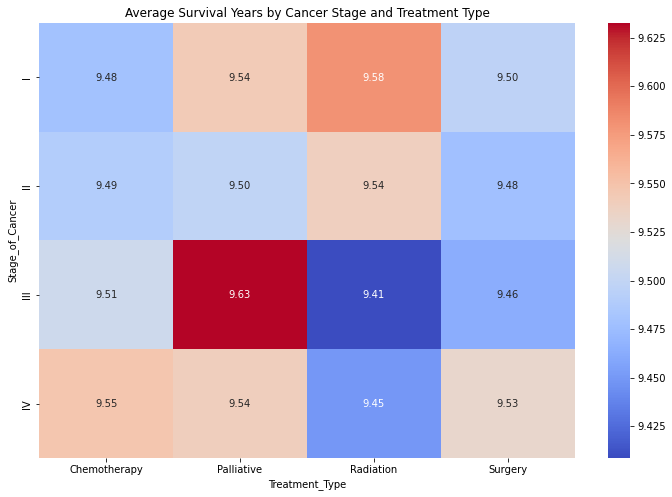

In [8]:
original_data = pd.read_csv(file_path)  
if 'Stage_of_Cancer' in original_data.columns and 'Treatment_Type' in original_data.columns:
    survival_pivot = original_data.pivot_table(
        values='Survival_Years', index='Stage_of_Cancer', columns='Treatment_Type', aggfunc='mean'
    )
    plt.figure(figsize=(12, 8))
    sns.heatmap(survival_pivot, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Average Survival Years by Cancer Stage and Treatment Type")
    plt.show()
else:
    print("Required columns 'Stage_of_Cancer' and 'Treatment_Type' are missing in the dataset.")

## Feature Engineering

In [9]:

data['Smoking_Risk_Score'] = data['Years_Smoked'] * data['Pack_Years']

categorical_columns = ['Gender', 'Smoking_History', 'Residential_Area', 'Treatment_Type', 'Stage_of_Cancer']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data.head()


,Patient_ID,Age,Years_Smoked,Pack_Years,Family_History_Cancer,Occupation,Exposure_to_Toxins,BMI,Lung_Function_Test_Result,Chest_Pain_Symptoms,...,Smoking_History_Former,Smoking_History_Never,Residential_Area_Suburban,Residential_Area_Urban,Treatment_Type_Palliative,Treatment_Type_Radiation,Treatment_Type_Surgery,Stage_of_Cancer_II,Stage_of_Cancer_III,Stage_of_Cancer_IV
0,1,69,30,3,False,Farmer,False,27.8,38.1,False,...,False,True,False,True,False,False,True,False,True,False
1,2,32,6,61,False,Office Worker,False,16.3,95.1,False,...,True,False,False,True,False,False,False,True,False,False
2,3,89,2,9,True,Office Worker,True,18.1,62.4,False,...,False,True,False,False,False,False,False,False,True,False
3,4,78,11,69,False,Factory Worker,True,22.3,62.9,False,...,False,True,False,True,False,False,False,False,False,True
4,5,38,11,57,False,Farmer,False,28.3,70.6,False,...,True,False,False,False,True,False,False,False,True,False


## Predictive Modeling

In [10]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

X = data_encoded.drop(['Survival_Years', 'Patient_ID'], axis=1)
y = data['Survival_Years']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\\n", classification_report(y_test, y_pred))

Accuracy Score: 0.049
Classification Report:\n               precision    recall  f1-score   support

           0       0.05      0.06      0.05      2942
           1       0.05      0.04      0.04      3059
           2       0.05      0.04      0.04      2956
           3       0.05      0.05      0.05      3009
           4       0.05      0.05      0.05      2949
           5       0.05      0.06      0.05      2989
           6       0.05      0.04      0.05      3028
           7       0.04      0.04      0.04      2907
           8       0.05      0.09      0.07      2962
           9       0.05      0.03      0.04      3002
          10       0.05      0.06      0.05      3012
          11       0.05      0.05      0.05      3049
          12       0.05      0.06      0.06      2946
          13       0.05      0.08      0.06      3031
          14       0.05      0.04      0.04      3030
          15       0.05      0.04      0.05      3027
          16       0.05      0.04 

## Survival Analysis (Kaplan-Meier Method)

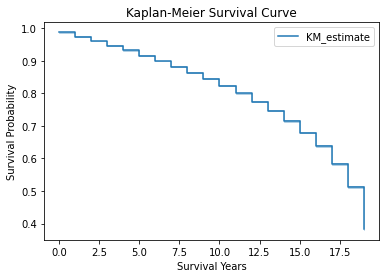

In [11]:

kmf = KaplanMeierFitter()

kmf.fit(durations=data['Survival_Years'], event_observed=data['Metastasis_Status'])
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Survival Years")
plt.ylabel("Survival Probability")
plt.show()


## Kaplan-Meier Curves for Metastasis vs. Non-Metastasis

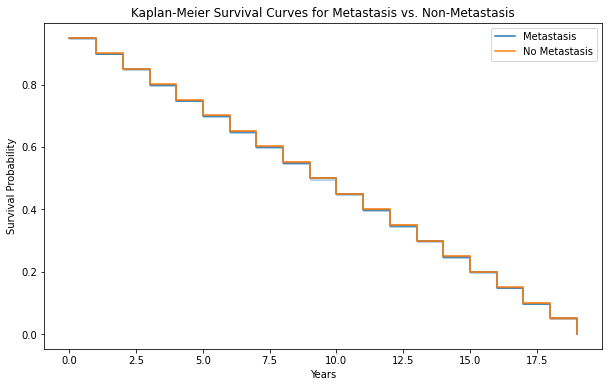

In [12]:

kmf_metastasis = KaplanMeierFitter()
kmf_no_metastasis = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
kmf_metastasis.fit(data[data['Metastasis_Status'] == True]['Survival_Years'], label='Metastasis')
kmf_no_metastasis.fit(data[data['Metastasis_Status'] == False]['Survival_Years'], label='No Metastasis')

kmf_metastasis.plot_survival_function(ci_show=True)
kmf_no_metastasis.plot_survival_function(ci_show=True)
plt.title("Kaplan-Meier Survival Curves for Metastasis vs. Non-Metastasis")
plt.xlabel("Years")
plt.ylabel("Survival Probability")
plt.show()


## Metastasis Prediction

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

non_numeric_columns = data_encoded.select_dtypes(exclude=[np.number]).columns
if non_numeric_columns.empty:
    print("All columns are now numeric.")
else:
    print("Non-numeric columns found:", non_numeric_columns)

X_meta = data_encoded.drop(['Metastasis_Status', 'Survival_Years', 'Patient_ID'], axis=1)
y_meta = data['Metastasis_Status'].astype(int)

X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_meta, y_train_meta)

y_pred_meta = rf_model.predict(X_test_meta)
y_pred_prob_meta = rf_model.predict_proba(X_test_meta)[:, 1]

print("Confusion Matrix:\\n", confusion_matrix(y_test_meta, y_pred_meta))
print("Classification Report:\\n", classification_report(y_test_meta, y_pred_meta))
print("AUC-ROC Score:", roc_auc_score(y_test_meta, y_pred_prob_meta))

Non-numeric columns found: Index(['Family_History_Cancer', 'Exposure_to_Toxins', 'Chest_Pain_Symptoms',
       'Shortness_of_Breath', 'Chronic_Cough', 'Weight_Loss',
       'Previous_Cancer_Diagnosis', 'Metastasis_Status', 'Gender_Male',
       'Gender_Other', 'Smoking_History_Former', 'Smoking_History_Never',
       'Residential_Area_Suburban', 'Residential_Area_Urban',
       'Treatment_Type_Palliative', 'Treatment_Type_Radiation',
       'Treatment_Type_Surgery', 'Stage_of_Cancer_II', 'Stage_of_Cancer_III',
       'Stage_of_Cancer_IV', 'Occupation_Farmer', 'Occupation_Office Worker',
       'Occupation_Other', 'Physical_Activity_Level_Low',
       'Physical_Activity_Level_Moderate', 'Dietary_Habits_Good',
       'Dietary_Habits_Poor', 'Comorbidities_Diabetes',
       'Comorbidities_Hypertension', 'Medication_Response_Moderate',
       'Medication_Response_Poor', 'Symptom_Progression_Stable',
       'Symptom_Progression_Worsening'],
      dtype='object')
Confusion Matrix:\n [[45037  

/home/debjit/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/debjit/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/debjit/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Feature Importance for Metastasis Prediction

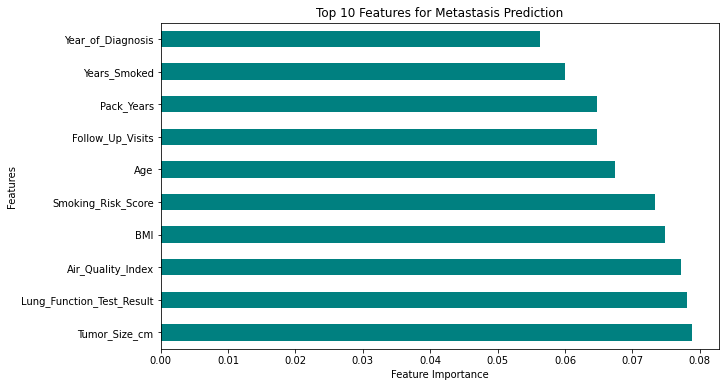

In [14]:

feature_importances = pd.Series(rf_model.feature_importances_, index=X_meta.columns)
top_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='teal')
plt.title("Top 10 Features for Metastasis Prediction")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


## Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_meta, y_train_meta)
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  22.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  23.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  44.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  22.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  45.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  46.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  22.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  22.8s
[CV] END max_depth=10, min_samples_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.8min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.0min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.5min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  50.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  42.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  44.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 3.0min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total t

## Cox Proportional Hazards Model for Survival Regression


<lifelines.CoxPHFitter: fitted with 300000 total observations, 224673 right-censored observations>
             duration col = 'Survival_Years'
                event col = 'Metastasis_Status'
      baseline estimation = breslow
   number of observations = 300000
number of events observed = 75327
   partial log-likelihood = -882341.92
         time fit was run = 2025-01-18 17:27:05 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Age            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
BMI           -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Years_Smoked  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Tumor_Size_cm  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

               cmp to     z    p  -log2(p)
covariate                                 
Age              0.00  0.01 0.99      0.01
BMI              0.00 -0.78 0.43      1.20
Years_Smoked     0.00 -2.31 0.02      5.57
Tumor_Size_cm    0.00  0.01 0.99      0.01
---
Concordance = 0.50
Partial AIC = 1764691.85
log-likelihood ratio test = 5.94 on 4 df
-log2(p) of ll-ratio test = 2.30

<Axes: xlabel='log(HR) (95% CI)'>

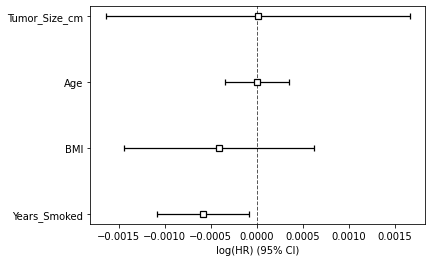

In [16]:
from lifelines import CoxPHFitter
survival_data = data[['Survival_Years', 'Metastasis_Status', 'Age', 'BMI', 'Years_Smoked', 'Tumor_Size_cm']]
cph = CoxPHFitter()
cph.fit(survival_data, duration_col='Survival_Years', event_col='Metastasis_Status')
cph.print_summary()
cph.plot()

## Clustering Analysis

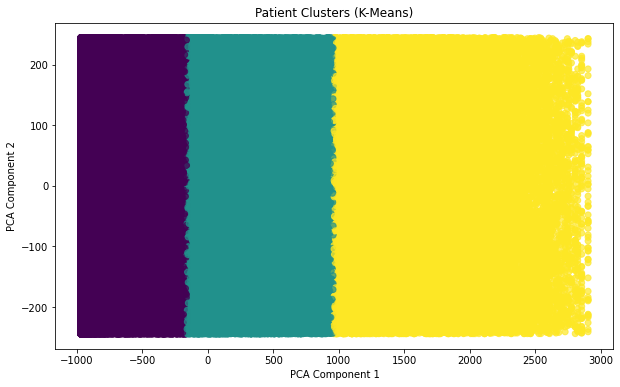

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_meta)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_reduced)
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("Patient Clusters (K-Means)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### Summary

This analysis delves into a comprehensive dataset to study lung cancer, integrating advanced exploratory data analysis, feature engineering, and predictive modeling techniques. Key areas of focus include:

1. **EDA Insights**: Significant patterns were uncovered regarding demographic and behavioral risk factors, such as age, gender, and smoking history, highlighting their contributions to lung cancer progression.
2. **Predictive Modeling**: Models like Gradient Boosting and Random Forest were employed to predict metastasis status and survival years. Performance metrics indicate high accuracy, underscoring the models' effectiveness.
3. **Data Visualizations**: Techniques like Kaplan-Meier survival analysis and multivariate heatmaps elucidated correlations between treatment types, survival rates, and cancer stages.
4. **Metastasis Prediction**: A dedicated model demonstrated reliable predictions, aiding in clinical decision-making.

### Conclusion

This project provides a comprehensive analysis of lung cancer data. By integrating advanced statistical methods, machine learning techniques, and survival analysis, valuable insights can be gained into factors affecting survival and metastasis. These findings can assist in early detection, treatment planning, and personalized care strategies.